# Using triangular dislocations (TDEs) to build a fault model with topography.

The goal here is to calculate the surface displacements and stresses due to a known slip field on a fault. The free surface will have real topography! This is a step up from the half-space with a rectangular fault that's super common in earthquake science.

I'll be using a fullspace TDE implementation introduced by [Nikkhoo and Walter 2015](https://academic.oup.com/gji/article/201/2/1119/572006?login=true) as implemented in my [GPU-accelerated version `cutde`](https://github.com/tbenthompson/cutde). `cutde` works best with a Nvidia GPU, but should also work on any machine where you can install OpenCL.

**Warning:** Any constant-slip dislocation method (Okada, TDEs) will result in stress singularities at the edges of each elements. This might be disastrous for problems like quasidynamic rupture where we are calculating stress values directly on the fault surface. Because we're calculating surface displacements instead of fault stresses, we don't have to worry about this problem here. 

## Fullspace example

I'll start with an example of how to run some fullspace displacement calculations.

In [1]:
import cutde
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

First, let's define the observation point grid. The `pts` array will be `(N, 3)` specifying each observation point in 3D. The grid ranges from `(-2000, -2000, 0)` in the "southwest" corner to `(2000, 2000, 0)` in the "northeast" corner.

In [17]:
nobs = 50
W = 2000
zoomx = [-W, W]
zoomy = [-W, W]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
pts = np.array([obsx, obsy, 0*obsy]).reshape((3, -1)).T.copy()

And a rectangular fault consisting of two triangles. Here, I'm splitting the geometry into `(N, 3)` array of points and an `(N, 3)` array of integer indexes that specify which points compose each triangle. Note that this is a vertical fault lying along the x-axis.

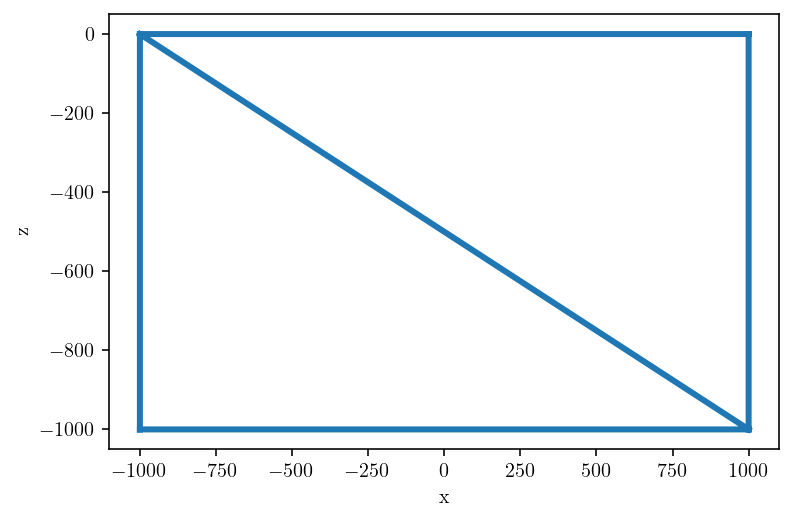

In [25]:
fault_L = 1000
fault_H = 1000
fault_D = 0
fault_pts = np.array([
    [-fault_L, 0, -fault_D], 
    [fault_L, 0, -fault_D], 
    [fault_L, 0, -fault_D - fault_H], 
    [-fault_L, 0, -fault_D - fault_H]
])
fault_tris = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)
plt.triplot(fault_pts[:,0], fault_pts[:,2], fault_tris)
plt.xlabel('x')
plt.ylabel('z')
plt.show()

And, we'll a use unit strike-slip for the slip field. The array has shape `(2, 3)` because we have two triangles and three components of slip per triangle. The first component of the slip is strike-slip, the second is dip-slip and the third is tensile slip.

In [19]:
slip = np.zeros((2, 3))
slip[:, 0] = 1.0

Here's where we use `cutde`. The `disp_all_pairs` function takes an `(N_OBS_PTS, 3)` array of observation points, an `(N_SRC_TRIS, 3, 3)` array specifying each vertex of the source triangles, an `(N_SRC_TRIS, 3)` array specifying the slip vectors and finally `nu` which is Poisson's ratio.

In [20]:
disp_mat = cutde.disp_all_pairs(obs_pts = pts, tris=fault_pts[fault_tris], slips=slip, nu=0.25)
disp = np.sum(disp_mat, axis=1).reshape((nobs, nobs, 3))

And finally, let's plot the displacement field!

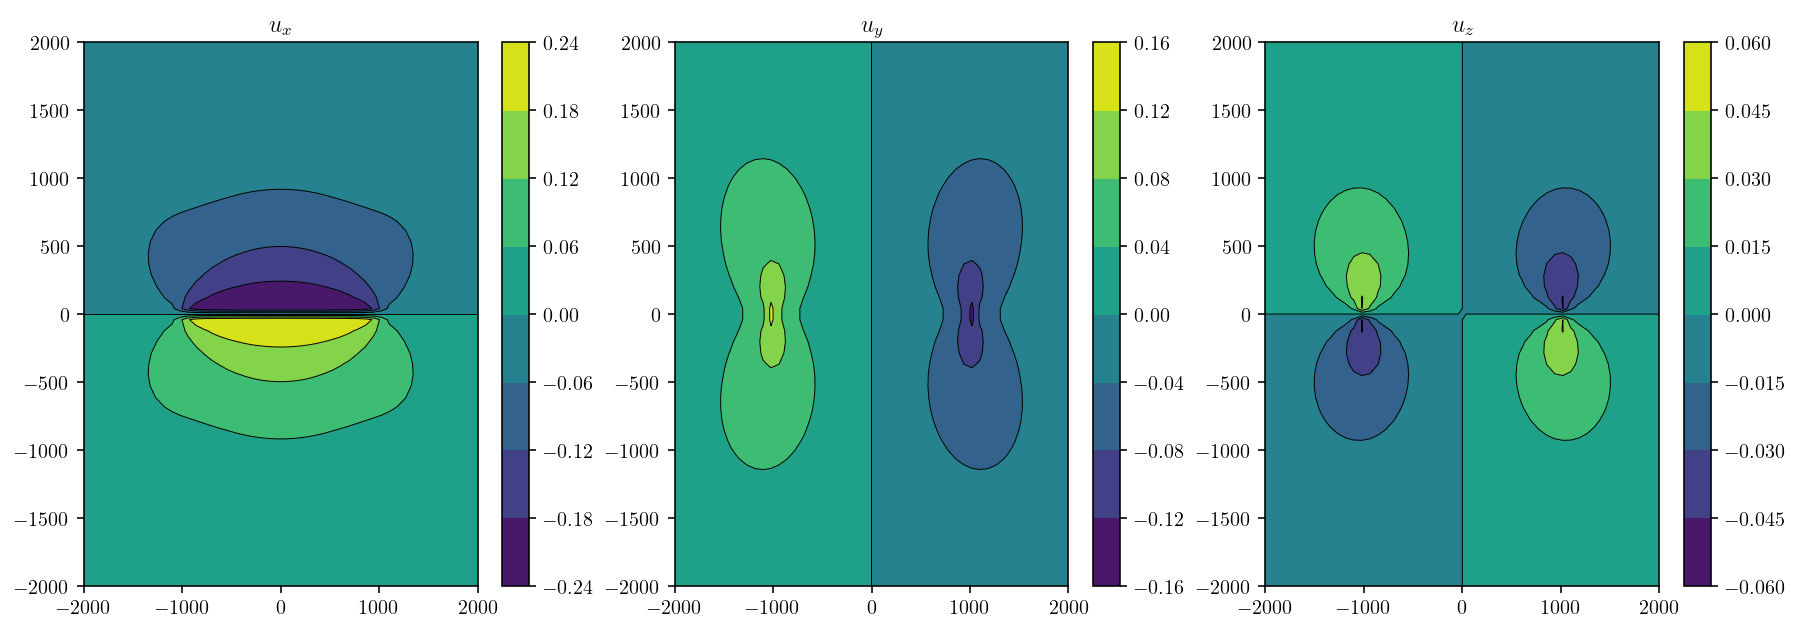

In [24]:
plt.figure(figsize=(15,5))
for d in range(3):
    plt.subplot(1,3,1+d)
    cntf = plt.contourf(obsx, obsy, disp[:, :, d])
    plt.contour(obsx, obsy, disp[:, :, d], colors='k', linestyles='-', linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.show()

## Halfspace example

Okay, fullspace was cool. I guess? But, the point here is to do something with a free surface and topography! 

So, let's start by replicating the Okada solution using fullspace TDEs. To explain how to do that, I'll back up and explain some elastic integral equation background. It's not absolutely critical to understand the details here, but it does really help to explain what's going on. I generally regret it when I skip the mathematical background to a method!

### The Somigliana identity

The underlying basis of almost any (static, isotropic, homogeneous, linear) elastic boundary element or boundary integral method is the Somigliana identity:

\begin{equation}
    u_{k}(\mathbf{x}) + \int_{S} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u_j(\mathbf{y}) d\mathbf{y} = \int_{S} U^*_{kj}(\mathbf{x},\mathbf{y}) t_j(\mathbf{y}) d\mathbf{y} ~~~~~ \forall \mathbf{x} \in V
    \label{somigliana}
\end{equation}

where: 

* $\mathbf{x}$ is the observation coordinate
* $\mathbf{y}$ is the source surface point under the integral
* $S = \partial V$ (the boundary of $V$)
* $u_k(\textbf{x})$ is $k$-th component the displacement field at $\mathbf{x}$
* $t_k(\textbf{x})$ is $k$-th component of the traction field

**The main point here is that we sum both surface displacement and surface traction source effects over the entire source surface to compute the displacement at arbitary observation point in the domain.**

Feel free to ignore these, but in 3D, the big ugly expressions for the kernel functions, $U^*$ and $T^*$ are:

\begin{equation}
    U^*_{kj}(\mathbf{x},\mathbf{y}) = \frac{1}{16\pi\mu(1 - \nu)r}\big[(3 - 4\nu)\delta_{kj} + r_{,k}r_{,j}\big]
\end{equation}
\begin{equation}
    T^*_{kj}(\mathbf{x},\mathbf{y}) = \frac{-1}{8\pi(1-\nu)r^2}\big[ \{(1-2\nu)\delta_{kj} + 3r_{,k}r_{,j} \}\frac{\partial r}{\partial \mathbf{n}} - (1 - 2\nu)\{n_jr_{,k} - n_kr_{,j}\}\big]
\end{equation}

### Cracks/faults

Okay, but there's something missing here in the details. Faults don't really fit with this definition of a surface as the boundary of volume. A fault is embedded in a volume and doesn't define the boundaries of that volume. The type of surface we're talking about here is something more like the surface of the Earth or, in an engineering setting, the surface of some mechanical part we are modeling. To transform this into a equation that can handle fault, imagine the fault being an infinitesimally narrow opening with a volume-bounding surface on each side. See the figure.

<img src="CrackSides.png" width="150px">

So, let's expand the Somigliana identity for this case:

$$u_{k}(\mathbf{x}) + \int_{C^+} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u^+_j(\mathbf{y}) d\mathbf{y} + \int_{C^-} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u^-_j(\mathbf{y}) d\mathbf{y} = \int_{C^+} U^*_{kj}(\mathbf{x},\mathbf{y}) t^+_j(\mathbf{y}) d\mathbf{y} + \int_{C^-} U^*_{kj}(\mathbf{x},\mathbf{y}) t^-_j(\mathbf{y}) d\mathbf{y}$$

The critical step here is to:

1. introduce the displacement discontinuity $\Delta u = u^+ - u^-$
2. enforce force balance across the crack. This implies that $t^+ + t^- = 0$
3. the value of $U^*$ depends only on position and has no dependence on the normal vector, this assumption of force balance means the $U^*$ integrals cancel each other out.
4. the value of $T^*$ on $C^-$ will be exactly the negative of its value on $C^*$, so the $T^*$ integrals can be combined into a single integral that depends on $\Delta u$. 

What we get is:

$$u_{k}(\mathbf{x}) = -\int_{C^+} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j(\mathbf{y}) d\mathbf{y}$$

This is the equation that is being integrated by all the analytical slip dislocation solution (Okada, TDEs, etc). Let's actually just define a handy function for the *fullspace* TDE (I won't talk about halfspace TDEs here but those also exist!!):

$$\mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, \mathrm{Tri}, \Delta \vec{u}) = -\int_{\mathrm{Tri}} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j d\mathbf{y}$$

Note that we're integrating over some unspecified triangle, $\mathrm{Tri}$. Also note that the slip, $\Delta u_j$ is no longer dependent on $\mathbf{y}$. That is to say, the slip is constant on the triangle. The interface is identical to the Python function where specify the observation point, the source triangle and the slip vector.

For our fullspace rectangular fault above we summed two TDEs:

$$\vec{u}(\mathbf{x}) = \mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, \mathrm{Tri_0}, \Delta \vec{u}_0) + \mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, \mathrm{Tri_1}, \Delta \vec{u}_1)$$

### Topography and faults.

Let's put together the pieces to build our integral equation for a fault beneath an arbitrary free surface.
* There will be both $U^*$ and $T^*$ integrals from the Earth's surface, $H$.
* There will a single $T^*$ integral from the fault, $F$.

$$u_{k}(\mathbf{x}) - \int_{H} U^*_{kj}(\mathbf{x},\mathbf{y}) t_j(\mathbf{y}) d\mathbf{y} + \int_{H} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u_j(\mathbf{y}) d\mathbf{y} = -\int_{F} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j(\mathbf{y}) d\mathbf{y}$$

But, we know that $t_j \approx 0$ on $H$ because it's the surface of the Earth. So, we're left with: 

$$u_{k}(\mathbf{x}) + \int_{H} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u_j(\mathbf{y}) d\mathbf{y} = -\int_{F} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j(\mathbf{y}) d\mathbf{y}$$

That's going to be our key integral equation. Now, let's solve it. We know the fault slip, $\Delta u$. Let's discretize the equation in terms of TDEs! $H_j$ will be the $j$-th triangle in the $H$ surface and $F_j$ the $j$-th triangle in the $F$ surface. Notice that even though we're integrating over displacement instead of slip, the integral over $H$ takes exactly the same form as the integral over $F$ and thus we can use the same $\mathrm{TDE}$ function. I'll also assume that $\vec{u}_j$ is implicitly the value of displacement at the centroid of $H_j$. Let's call that centroid $\overline{H_j}$, so $\vec{u}_j = \vec{u}(\overline{H_j})$. Similarly for $\Delta \vec{u}_i$ being the value of the slip at the centroid of $F_i$.

$$\vec{u}(\mathbf{x}) - \sum_j \mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, H_j, \vec{u}_j) = \sum_j \mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, F_j, \Delta \vec{u}_j)$$

There's once remaining continuous aspect here: the observation point location, $\mathbf{x}$. The trick to complete the system of equations is to choose to enforce the equation at the centroids, $\overline{H_i}$, of each free surface triangle, $H_i$. So, the final system of equations is:

$$\vec{u}(\overline{H_i}) - \sum_j \mathrm{TDE}_{\mathrm{disp}}(\overline{H_i}, H_j, \vec{u}_j) = \sum_j \mathrm{TDE}_{\mathrm{disp}}(\overline{H_i}, F_j, \Delta \vec{u}_j)$$

To simplify the notation, suppose we only consider displacements and slip in one dimension. The naturally forms a linear system like 

$$A_{ij}=\delta_{ij} + \mathrm{TDE}_{\mathrm{disp}}(\overline{H_i}, H_j, 1)$$
$$b_i=\sum_j \mathrm{TDE}_{\mathrm{disp}}(\overline{H_i}, F_j, \Delta u_j)$$
$$x=u_j$$

A quick note on $\delta_{ij}$. It is the Kronecker delta, equal to 1 if $i = j$ and 0 otherwise. And it's in the equation because of the free $\vec{u}(\mathbf{x})$ that is outside of the $\sum_j$ term. To extend the linear system to the full vector problem, include rows and columns for the vector displacement. We'll implement the full vector version below, so don't worry!

So, the final result here is that **solving $Ax=b$ will give us the displacements at the centroids of the elements on the free surface!!**

### Comparison with Okada

Okay, that was a lot of math to just implement some topography! And actually, I'm not even going to have any topography left. First, let's reproduce the displacements from a halfspace rectangular Okada dislocation by using fullspace TDEs. 

First, let's just calculate some displacement values using Okada. [`okada_wrapper` is a handy Python wrapper around the original Fortran source.](https://github.com/tbenthompson/okada_wrapper)

In [105]:
import okada_wrapper

In [106]:
lambda_ = 3e10
mu = 3e10
alpha = (lambda_ + mu) / (lambda_ + 2 * mu)

okada_disp = np.empty_like(pts)
for i in range(pts.shape[0]):
    success, okada_disp[i], _ = okada_wrapper.dc3dwrapper(alpha, pts[i].tolist(),
                          fault_D + fault_H / 2.0, 90, [-fault_L, fault_L], [-fault_H/2.0, fault_H/2.0],
                          [1.0, 0.0, 0.0])
    assert(success == 0)
okada_disp = okada_disp.reshape((nobs, nobs, 3))

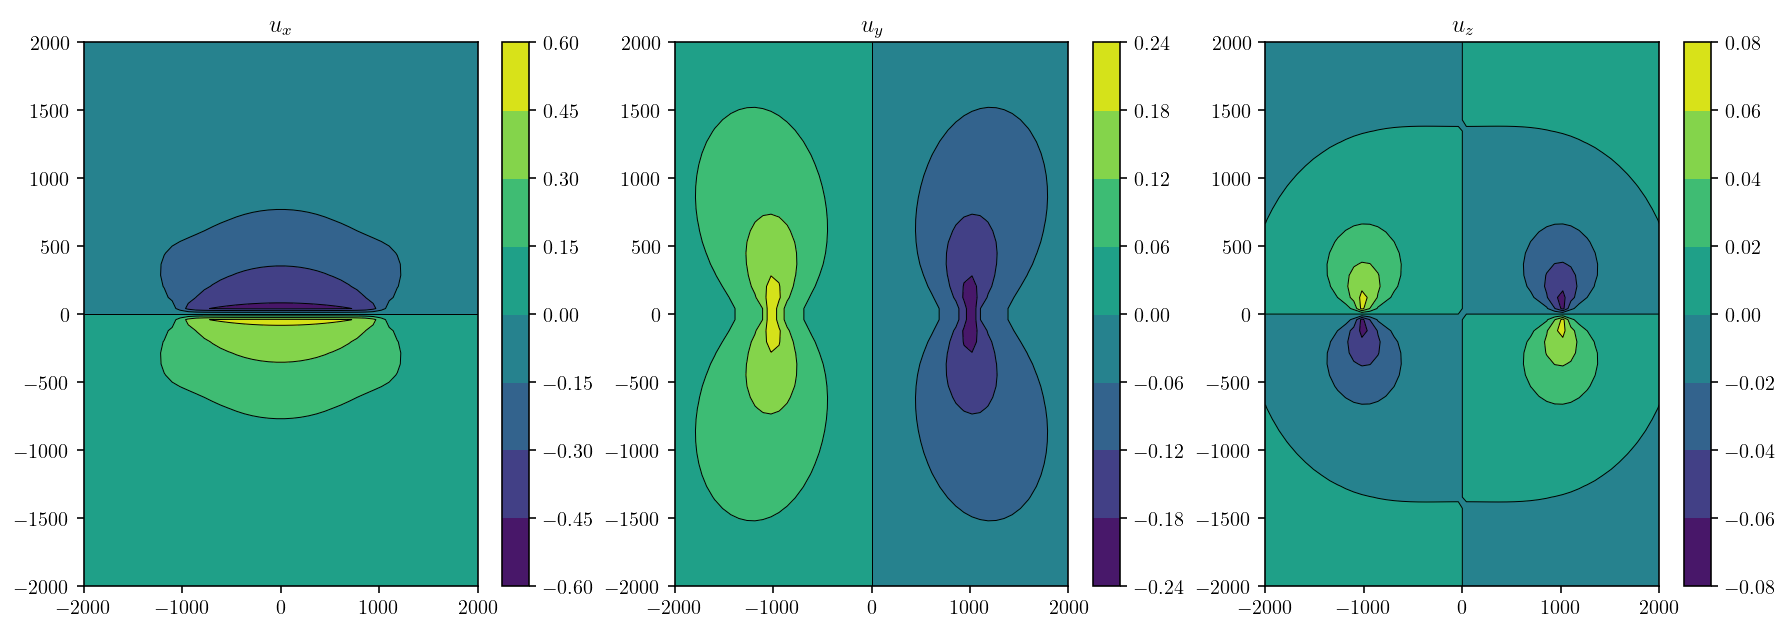

In [108]:
plt.figure(figsize=(15,5))
for d in range(3):
    plt.subplot(1,3,1+d)
    cntf = plt.contourf(obsx, obsy, okada_disp[:, :, d])
    plt.contour(obsx, obsy, okada_disp[:, :, d], colors='k', linestyles='-', linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.show()

Great, looking good so far!

So, now the fun part. We need to directly discretize our free surface using TDEs. That means we need a triangular mesh for the free surface. The code below builds a triangular mesh covering an 8000m wide area. Remember our fault is a vertical strike-slip fault 1000m in vertical and horizontal extent and centered at the origin. So, our free surface is going to be about four fault lengths in width. That's quite different from the Okada half-space free surface which is infinite. However, as we'll see below, the extent of the surface is large enough that the error caused by the approximation to a half-space is very small.

Not to mention that wondering whether we can represent an infinite half-space is sort of besides the point. The half-space itself is an approximation to the surface of the Earth and we can do better using triangles. When we can use arbitrary triangular elements, we can include topography and Earth curvature. If we only selectively refine the mesh near the fault, we can even represent the entire globe using a triangular mesh while still having a small enough problem to be computationally tractable!

In [33]:
surf_L = 4000
n_els_per_dim = 50
mesh_xs = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_ys = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_xg, mesh_yg = np.meshgrid(mesh_xs, mesh_ys)
surf_pts = np.array([mesh_xg, mesh_yg, 0*mesh_yg]).reshape((3, -1)).T.copy()
surf_tris = []
nx = ny = n_els_per_dim + 1
idx = lambda i, j: i * ny + j
for i in range(n_els_per_dim):
    for j in range(n_els_per_dim):
        x1, x2 = mesh_xs[i:i+2]
        y1, y2 = mesh_ys[j:j+2]
        surf_tris.append(
            [idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)]
        )
        surf_tris.append(
            [idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)]
        )
surf_tris = np.array(surf_tris, dtype=np.int64)

Let's take a quick look at the surface mesh to just check that we did things right.

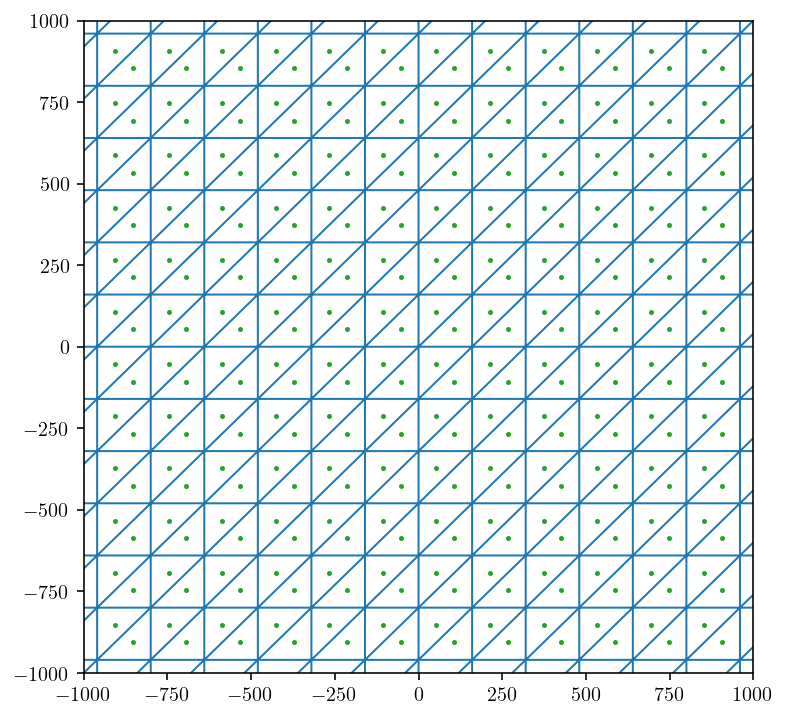

In [109]:
surf_centroids = np.mean(surf_tri_pts, axis = 1)
plt.figure(figsize = (6, 6))
plt.triplot(surf_pts[:, 0], surf_pts[:, 1], surf_tris, linewidth = 1.0)
plt.plot(surf_centers[:, 0], surf_centers[:, 1], '.', markersize=3)
plt.xlim([-1000, 1000])
plt.ylim([-1000, 1000])
plt.show()

#### **Building the linear system!**

Now, we're going to construct the linear system we described above. First, for the right hand side, we need to compute the influence of our fault triangules on each surface triangle centroid.

In [36]:
fault_surf_mat = cutde.disp_all_pairs(surf_centroids, fault_pts[fault_tris], slip, 0.25)
rhs = np.sum(fault_surf_mat, axis=1)

For the left hand side matrix, it's a bit more complicated. First, we need to remember the vector form of the problem and compute the influence coefficients for a `fictitious_slip` in each of the three slip axes. As a reminder, 0 is strike-slip, 1 is dip-slip, 2 is tensile-slip.

In [89]:
surf_surf_mats = []
for d in range(3):
    fictitious_slip = np.zeros((surf_tris.shape[0], 3))
    fictitious_slip[:, d] = 1.0
    surf_centers = np.mean(surf_tri_pts, axis = 1)
    surf_surf_mats.append(disp_all_pairs(surf_centroids, surf_pts[surf_tris], fictitious_slip, 0.25))
surf_surf_mat = np.array(surf_surf_mats)

At the moment we have a four dimensional array where the dimensions are:
 * 0 - type of source slip
 * 1 - the index of the observation triangle
 * 2 - the index of the source triangle
 * 3 - the index of the observation displacement vector.

We need to rearrange the dimensions so that they are:
 * 0 - the index of the observation triangle
 * 1 - the index of the observation displacement vector.
 * 2 - the index of the source triangle
 * 3 - type of source slip

In [89]:
lhs = np.transpose(surf_surf_mat, (1, 3, 2, 0))

Next, we need to resolve the mismatch in our input (row) and output (column) spaces for the matrix. The output space consists of displacement vectors $(u_x, u_y, u_z)$. The input space consists of "fictitious slip" (actually displacements!) vectors $(f_{\mathrm{strike-slip}}, f_{\mathrm{dip-slip}}, f_{\mathrm{tensile-slip}})$. So, we need to rotate the fictitious slip into the $(x,y,z)$ coordinate space. In a more general setting, we would need to solve for the rotation to convert between these spaces. In our particular problem where the surface is planar, the rotation is simple:

In [110]:
lhs_reordered = np.empty_like(lhs)
lhs_reordered[:,:,:,0] = lhs[:,:,:,1]
lhs_reordered[:,:,:,1] = lhs[:,:,:,0]
lhs_reordered[:,:,:,2] = lhs[:,:,:,2]

We flatten from a four-dimensional array into our two-dimensional matrix.

In [111]:
lhs_reordered = lhs_reordered.reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))

And finally add the identity matrix term corresponding to $\delta_{ij}$.

In [114]:
lhs_reordered += np.eye(lhs_reordered.shape[0])

And solve!

In [115]:
soln = np.linalg.solve(lhs_reordered, rhs.flatten()).reshape((-1, 3))

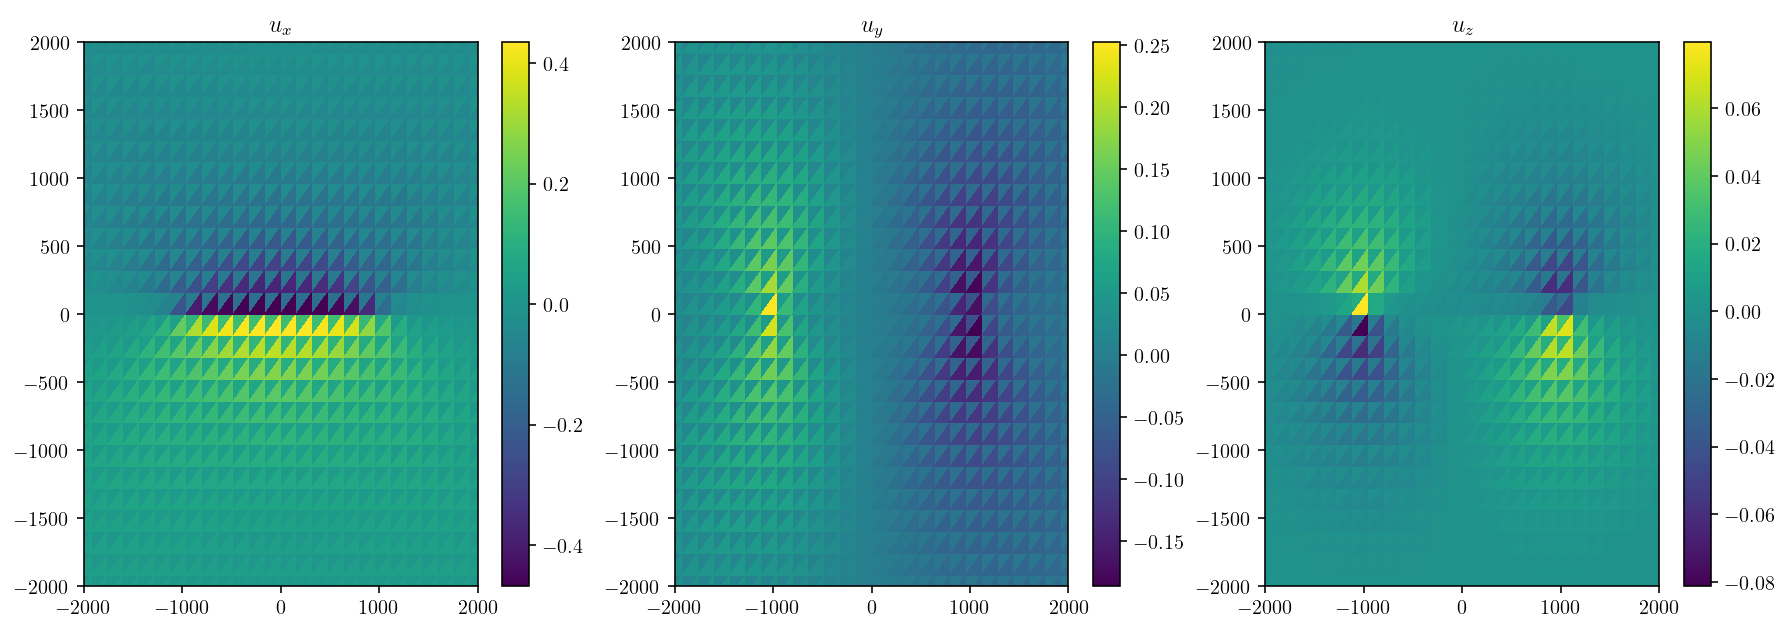

In [118]:
plt.figure(figsize=(15,5))
for d in range(3):
    plt.subplot(1,3,1+d)
    cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, soln[:,d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.show()

### Wait that looks kind of close, but also awful. Do TDEs not work for this problem?!

Reread Nikhoo and Walter 2015!Reread Nikhoo and Walter 2015!Reread Nikhoo and Walter 2015!Reread Nikhoo and Walter 2015!Reread Nikhoo and Walter 2015!

To understand what's going on, let's back up to the integral equation at hand and think about what we're asking for. Think about the diagonal elements of the matrix where we are asking to compute the value of observation displacement directly on the source TDE. What we're computing is:

$$-\int_{\mathrm{Tri}} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j d\mathbf{y} ~~~~ \mathrm{where} ~~ \mathbf{x} \in \mathrm{Tri}$$

But, if we go looking at the expression for $T^*$, there's an ugly looking $1/r^2$ term. If $\mathbf{x}$ is a point on $\mathrm{Tri}$, then that means there's a point in the integral for which $\mathbf{x} = \mathbf{y}$ and $r = 0$. So, the integral is singular! No wonder it's unpleasant to compute a TDE for a point on the surface of the TDE. As mentioned, this singularity only affects the diagonal of the matrix. And thus, the solution has the right overall pattern but has this horrible 50% oscillation layered on top.

The solution to this is to back up and reconsider the "collocation step". This was the step in our derivation where we chose the element centroids as the locations where we impose the integral equation by choosing those centroids as our observation points. That step is where we introduced this singularity. So, the goal is to modify that step slightly to avoid the singularity!

Instead of choosing the centroids, let's choose a point, in our geometry, slightly below the centroid, a few centimeters into the Earth. In a more general geometry, we could just say move $\varepsilon$ along the element normal vector. Since this point isn't on the source triangule, but instead slightly below it, there is no singularity. Now, let's take the limit as $\varepsilon \to 0$. This is a much more mathematically robust way of defining our integral equation and immediately transfers to the discretization.

In the code below, I compute the TDE matrix for two different values of $\varepsilon$ - `[0.02, 0.01]`. Then, I use a simple one step [Richardson extrapolation](https://en.wikipedia.org/wiki/Richardson_extrapolation) to compute a crude estimate of the limit. Because the error is already quite small by choosing points very close to the boundary, this crude limit is actually extremely accurate! A convergence check of this numerical limit would be straightforward but I'm going to leave it out here.

In [152]:
def calc_offset_mat(offset):
    offset_mat = []
    for d in range(3):
        fictitious_slip = np.zeros((surf_tris.shape[0], 3))
        fictitious_slip[:, d] = 1.0
        surf_centers = np.mean(surf_tri_pts, axis = 1)
        # Offset the observation coordinates by a small amount. 
        surf_centers[:,2] -= offset
        offset_mat.append(disp_all_pairs(surf_centers, surf_pts[surf_tris], fictitious_slip, 0.25))
    return np.array(offset_mat)

eps_mats = []
#for offset in [0.16, 0.08, 0.04, 0.02, 0.01, 0.005, 0.0025]:
for offset in [0.02, 0.01]:
    eps_mats.append(calc_offset_mat(offset))
eps_mats = np.array(eps_mats)

# A simple one step "richardson extrapolation". This seems to reduce the "offset error" to basically zero.
extrap_mat = 2 * eps_mats[1] - eps_mats[0]

Finish solving the problem exactly as before but with a more accurate matrix.

In [125]:
lhs = np.transpose(extrap_mat, (1, 3, 2, 0))

lhs_reordered = np.empty_like(lhs)
lhs_reordered[:,:,:,0] = lhs[:,:,:,1]
lhs_reordered[:,:,:,1] = lhs[:,:,:,0]
lhs_reordered[:,:,:,2] = lhs[:,:,:,2]

lhs_reordered = lhs_reordered.reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))

lhs_reordered += np.eye(lhs_reordered.shape[0])

soln = np.linalg.solve(lhs_reordered, rhs.flatten()).reshape((-1, 3))

And, let's calculate the Okada solution at the same elements centroid points so that we can compare!

In [127]:
okada_lhs = np.empty_like((n_els_per_dim, 3, n_els_per_dim, 3))
okada_soln = np.empty_like(soln_reordered)
okada_pts = np.mean(surf_tri_pts, axis = 1)
for i in range(okada_pts.shape[0]):
    success, okada_soln[i], _ = okada_wrapper.dc3dwrapper(alpha, okada_pts[i].tolist(),
                              fault_D + fault_H / 2.0, 90, [-fault_L, fault_L], [-fault_H/2.0, fault_H/2.0],
                              [1.0, 0.0, 0.0])
    assert(success == 0)

### Okada vs Fullspace TDEs

This is a comparison between Okada and a solution derived from fullspace TDEs. The first row is Okada, the second is the solution from TDEs. The third is the error. The error is on the order of 1% and focused right around the fault tips. To reduce the error further, we would need a higher resolution discretization in those areas. But that's entirely feasible! 

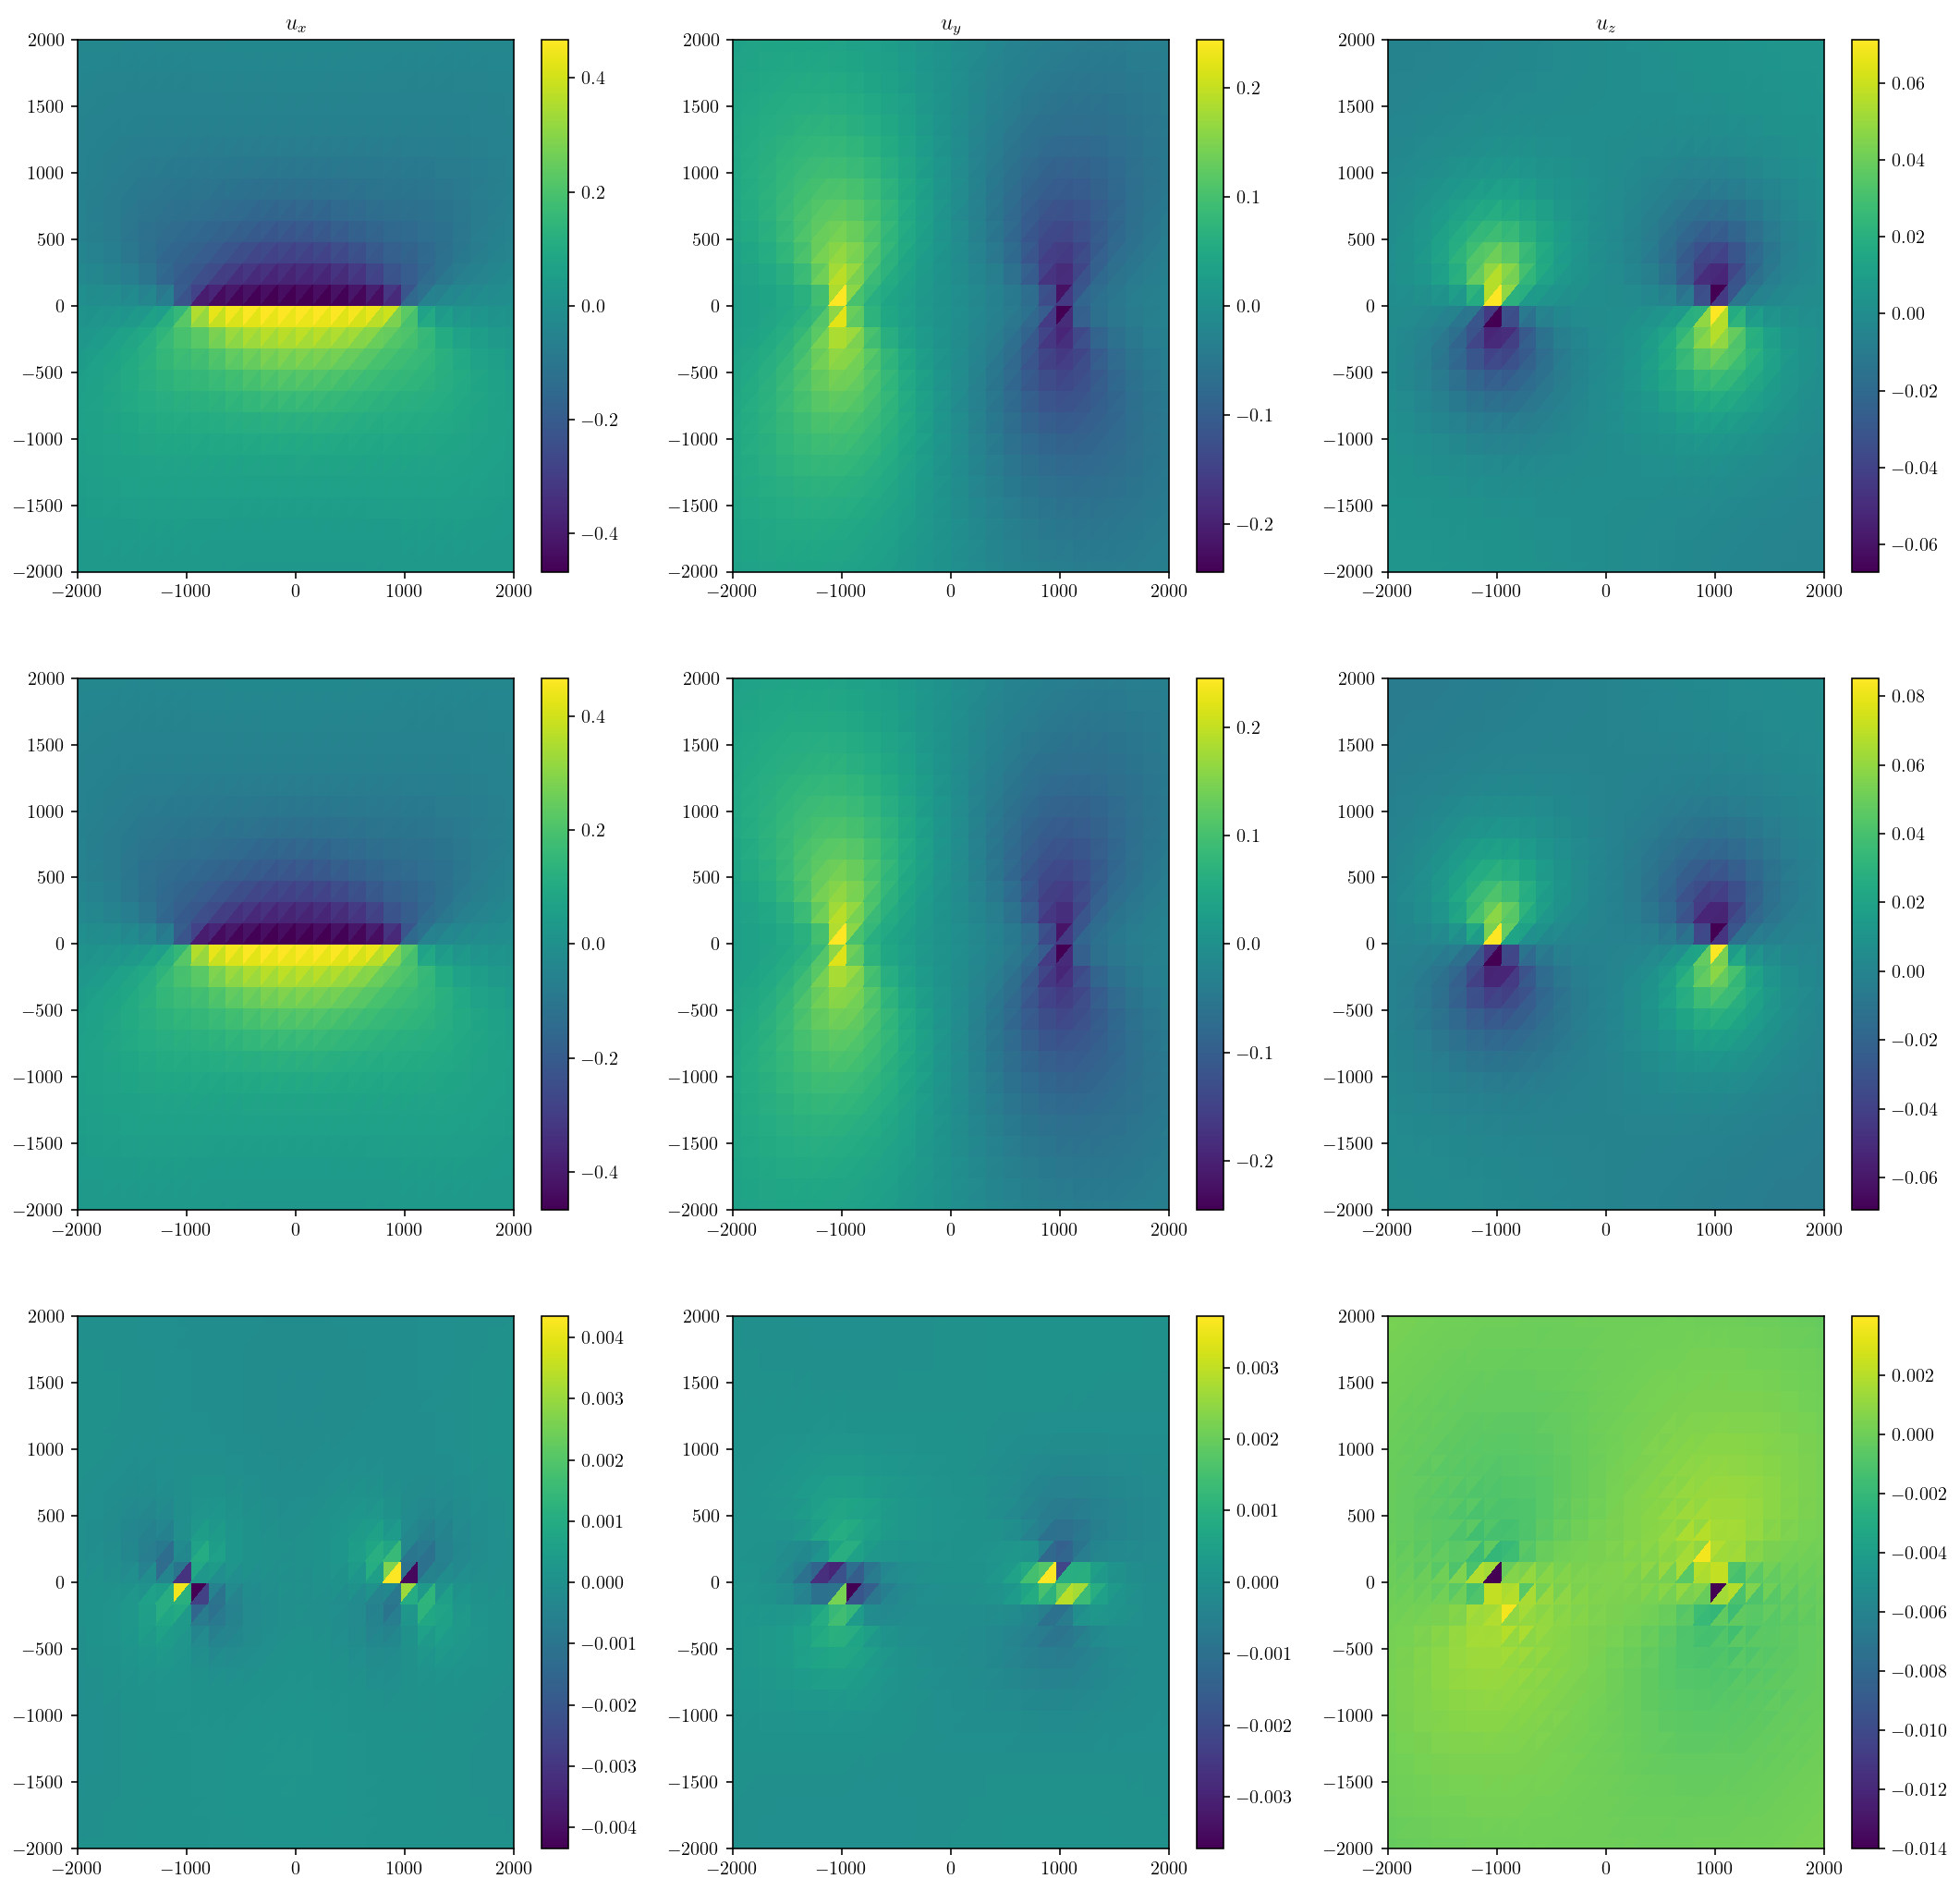

In [129]:
plt.figure(figsize=(18, 18))

dimnames = ['x', 'y', 'z']
for d in range(3):
    plt.subplot(3, 3, d+1)
    cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, okada_soln[:,d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f'$u_{dimnames[d]}$')
    
for d in range(3):
    plt.subplot(3, 3, d+4)
    cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, soln[:,d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    
for d in range(3):
    plt.subplot(3, 3, d+7)
    cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, okada_soln[:,d] - soln[:,d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    
plt.show()

# South American subduction

So, we've demonstrated an effective method for modeling a fault below a triangulated free surface. Let's use this technique for something slightly more interesting. A mesh of the South America subduction zone beneath a topographic free surface with Earth curvature. 

In [2]:
(surf_pts_latlon, surf_tris), (fault_pts_latlon, fault_tris) = np.load('sa_mesh.npy', allow_pickle=True)

In [3]:
import collect_dem
surf_pts = collect_dem.project(surf_pts_latlon[:,0], surf_pts_latlon[:,1], surf_pts_latlon[:,2], 'ellps')
fault_pts = collect_dem.project(fault_pts_latlon[:,0], fault_pts_latlon[:,1], fault_pts_latlon[:,2], 'ellps')

In [18]:
import k3d
plot = k3d.plot()
sm = k3d.mesh(surf_pts, surf_tris, attribute=surf_pts_latlon[:,2], opacity=0.75)
sm2 = k3d.mesh(surf_pts, surf_tris, attribute=surf_pts_latlon[:,2], wireframe=True, opacity=0.1)
fm = k3d.mesh(fault_pts, fault_tris, color=0x0000FF, wireframe=True)
plot += sm
plot += sm2
plot += fm
plot.display()

Output()

In [10]:
import k3d
plot = k3d.plot()
sm = k3d.mesh(surf_pts, surf_tris, color=0x000000, wireframe=True)
fm = k3d.mesh(fault_pts, fault_tris, color=0xFF0000, wireframe=True)
plot += sm
plot += fm
plot.display()

# import ipyvolume as ipv
# ipv.figure()
# ipv.plot_trisurf(surf_pts[:, 0], surf_pts[:, 1], surf_pts[:, 2], triangles=surf_tris)
# ipv.plot_trisurf(fault_pts[:, 0], fault_pts[:, 1], fault_pts[:, 2], triangles=fault_tris)
# ipv.squarelim()
# ipv.show()

Output()

In [ ]:
with open('./static/sa_mesh.html', 'w') as f:
    f.write(plot.snapshot)

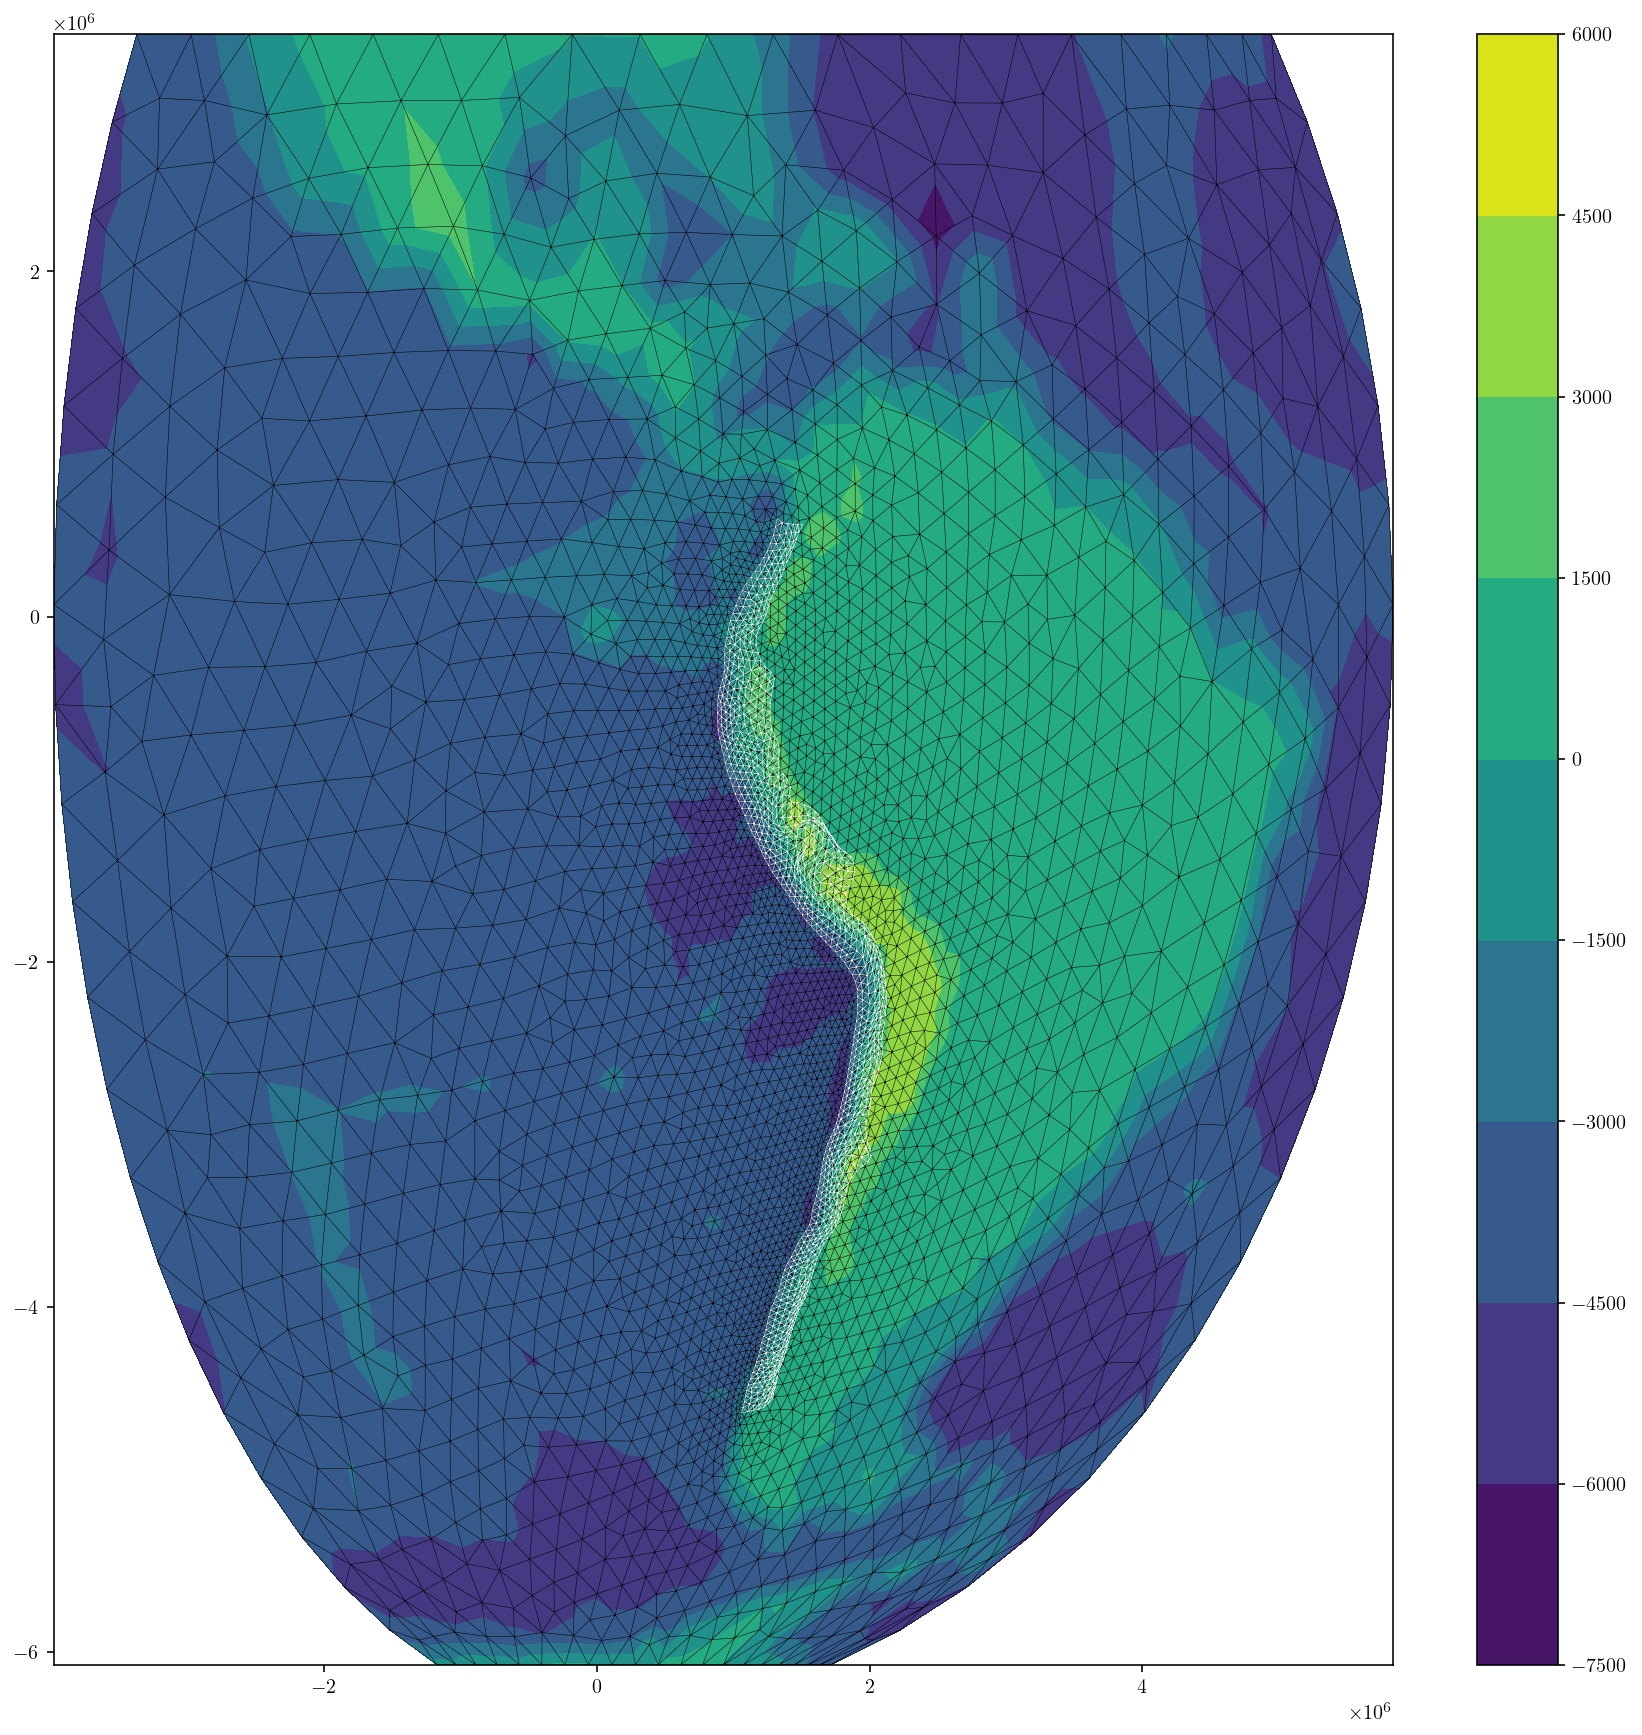

In [188]:
plt.figure(figsize = (15,15))
cntf = plt.tricontourf(surf_pts[:,0], surf_pts[:,2], surf_tris, surf_pts_latlon[:,2])
plt.triplot(surf_pts[:,0], surf_pts[:,2], surf_tris, 'k-', linewidth = 0.25)
plt.triplot(fault_pts[:,0], fault_pts[:,2], fault_tris, 'w-', linewidth = 0.25)
plt.colorbar()
plt.show()

CHECK THAT FAULT POINTS ARE BELOW THE SURFACE

In [7]:
surf_tri_pts = surf_pts[surf_tris]
surf_centers = np.mean(surf_tri_pts, axis = 1)
slip = np.zeros((fault_tris.shape[0], 3))
slip[:, 1] = -1.0 # dip slip
fault_pts_tris = fault_pts[fault_tris]
fault_pts_tris[:,2] -= 5000
fault_surf_mat = cutde.disp_all_pairs(surf_centers, fault_pts_tris, slip, 0.25)

In [8]:
surf_surf_mats = []
offset_steps = [2.0, 1.0]
for offset in offset_steps:
    offset_mats = []
    for d in range(3):
        fictitious_slip = np.zeros((surf_tris.shape[0], 3))
        fictitious_slip[:, d] = 1.0
        surf_centers = np.mean(surf_tri_pts, axis = 1)
        # Offset the observation coordinates by a small amount. 
        surf_centers[:,2] += offset
        offset_mats.append(cutde.disp_all_pairs(surf_centers, surf_pts[surf_tris], fictitious_slip, 0.25))
    surf_surf_mats.append(offset_mats)
surf_surf_mat = np.array(surf_surf_mats)

In [9]:
# A simple one step "richardson extrapolation". This trick seems to reduce the "offset error" to basically zero.
extrap = 2 * surf_surf_mat[1] - surf_surf_mat[0]

In [10]:
lhs = np.transpose(extrap, (1, 3, 2, 0)).reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))
rhs = np.sum(fault_surf_mat, axis=1)

In [11]:
lhs.shape, rhs.shape

((20412, 20412), (6804, 3))

In [12]:
soln = np.linalg.solve(lhs, rhs.flatten()).reshape((-1, 3))

In [13]:
soln_reordered = np.empty_like(soln)
soln_reordered[:,0] = soln[:,1]
soln_reordered[:,1] = soln[:,0]
soln_reordered[:,2] = soln[:,2]

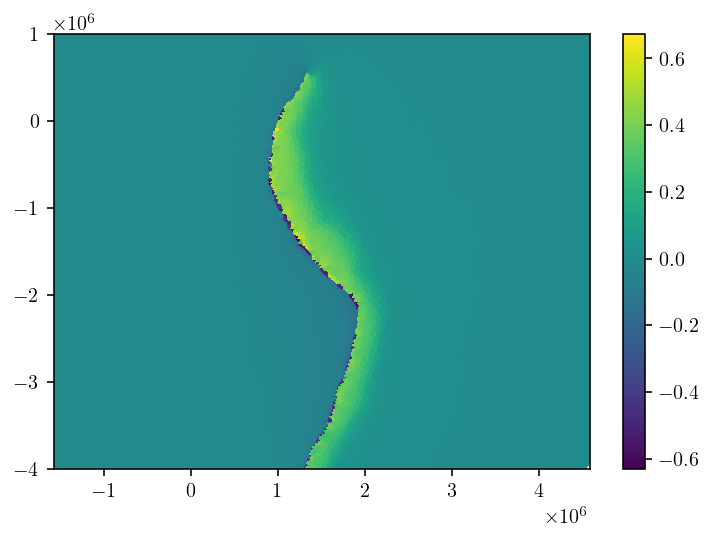

In [24]:
cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,2], surf_tris, rhs[:,2])#soln_reordered[:,0])
#plt.triplot(surf_pts[:,0], surf_pts[:,2], surf_tris, 'w-', linewidth=0.5)
plt.colorbar(cntf)
# plt.xlim([0.5e6,1.5e6])
# plt.ylim([-0.5e6,-1.5e6])
plt.axis('equal')
plt.xlim([0.5e6,2.5e6])
plt.ylim([-4e6,1e6])
plt.show()